In [1]:
import pandas as pd
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import confusion_matrix
import torch
from datasets import Dataset, DatasetDict
import evaluate
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, log_loss, roc_curve, auc
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme(style="dark")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return clf_metrics.compute(predictions=predictions, references=labels)

df = pd.read_csv('entities.csv', sep=',')
df.rename(columns={'chef':'label', 'texte':'text'}, inplace=True)
df.label = df.label.astype('int')
df

,text,label
0,Breton Cyrille menuisier 25 Garçon française,0
1,Ferazzi Auguste vitrier 30 Garçon Piémontaise,1
2,Machol Pierre vitrier 24 Garçon Piémontaise,1
3,Desbois Alexandre prop re 48 Homme marié franç...,1
4,Vignat Zélie prop re sa fe 30 française,0
...,...,...
25075,Chameton-Dideron Marie chef 1869 idem Pailharès,1
25076,Ode Marie ouv chaus res chef Cara 1863 idem St...,1
25077,Berni Nello manoeuvre chef Baretto 1886 italie...,1
25078,Berni-Laureti Annunziata épouse 1887 idem idem,0


In [2]:
dataset = Dataset.from_pandas(df)

train_testvalid = dataset.train_test_split(0.2, seed=42)
# Split the 10% test + valid in half test, half valid
train_valid = train_testvalid['train'].train_test_split(0.2, seed=42)
# gather everyone if you want to have a single DatasetDict
train_test_valid_dataset = DatasetDict({
    'train': train_valid['train'],
    'test': train_testvalid['test'],
    'valid': train_valid['test']})


dataset = train_test_valid_dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16051
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 5016
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 4013
    })
})

In [3]:
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(dataset['train']['text'])
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
X_train = X_tfidf

X_counts = count_vect.transform(dataset['valid']['text'])
X_tfidf = tfidf_transformer.transform(X_counts)
X_valid = X_tfidf

X_counts = count_vect.transform(dataset['test']['text'])
X_tfidf = tfidf_transformer.transform(X_counts)
X_test = X_tfidf

y_train = dataset['train']['label']
y_test = dataset['test']['label']
y_valid = dataset['valid']['label']

Accuracy:  0.9266347687400319
F1:  0.8415159345391904
Precision:  0.8061056105610561
Recall:  0.8801801801801802
Log loss:  0.19994486057239796


Text(0.5, 1.0, 'ROC curve - AUC: 0.9619847958557637')

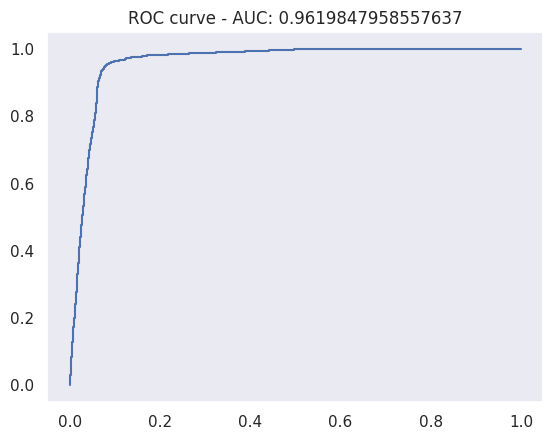

In [19]:
clf_logreg = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)
y_pred_logreg = clf_logreg.predict(X_test)
y_pred = y_pred_logreg
y_pred_proba = clf_logreg.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
log_loss_score = log_loss(y_test, y_pred_proba)
roc_logreg = roc_curve(y_test, y_pred_proba[:,1])
print("Accuracy: ", accuracy)
print("F1: ", f1)
print("Precision: ", precision)
print("Recall: ", recall)
print("Log loss: ", log_loss_score)
auc = np.trapz(roc_logreg[1], roc_logreg[0])


plt.plot(roc_logreg[0], roc_logreg[1])
plt.title("ROC curve - AUC: " + str(auc))

In [20]:

id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
).to(device)
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
def preprocess_function(examples, batched = True):
    return tokenizer(examples["text"], truncation=True)

tokenized_text = dataset.map(preprocess_function, batched=True)
training_args = TrainingArguments(
    output_dir="distilbert",
    learning_rate=7e-6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=1,
    fp16 = True)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_text["train"],
    eval_dataset=tokenized_text["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/16051 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/5016 [00:00<?, ? examples/s]

Map:   0%|          | 0/4013 [00:00<?, ? examples/s]

/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.253700,0.183618,0.931971,0.851711,0.801636,0.908459
2,0.188200,0.178173,0.931224,0.854584,0.783575,0.939745
3,0.176100,0.182569,0.934214,0.858065,0.800401,0.924681
4,0.167000,0.183469,0.933715,0.856061,0.803046,0.916570


TrainOutput(global_step=2008, training_loss=0.19606789904999067, metrics={'train_runtime': 130.0472, 'train_samples_per_second': 493.698, 'train_steps_per_second': 15.441, 'total_flos': 382958851182900.0, 'train_loss': 0.19606789904999067, 'epoch': 4.0})

Text(0.5, 1.0, 'ROC curve - AUC: 0.9664188381930318')

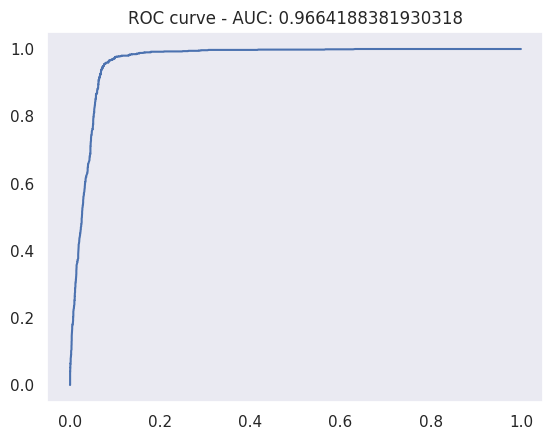

In [21]:
y_pred_distil = trainer.predict(tokenized_text["test"])

y_pred = y_pred_distil


roc_distilbert = roc_curve(y_test, y_pred.predictions[:,1])
auc = np.trapz(roc_distilbert[1], roc_distilbert[0])
plt.plot(roc_distilbert[0], roc_distilbert[1])
plt.title("ROC curve - AUC: " + str(auc))


In [22]:
str = "cmarkea/distilcamembert-base"

tokenizer = AutoTokenizer.from_pretrained(str)


def preprocess_function(examples, batched = True):
    return tokenizer(examples["text"], truncation=True)


id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

tokenized_text = dataset.map(preprocess_function, batched=True)

model = AutoModelForSequenceClassification.from_pretrained(
    str, num_labels=2, id2label=id2label, label2id=label2id
).to(device)


training_args = TrainingArguments(
    output_dir="distilCAMEMbert",
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.1,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=1,
    fp16 = True)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_text["train"],
    eval_dataset=tokenized_text["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

Map:   0%|          | 0/16051 [00:00<?, ? examples/s]

Map:   0%|          | 0/5016 [00:00<?, ? examples/s]

Map:   0%|          | 0/4013 [00:00<?, ? examples/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at cmarkea/distilcamembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.250000,0.177436,0.930725,0.851337,0.790467,0.922364
2,0.188400,0.176616,0.931473,0.854574,0.785992,0.936269
3,0.177400,0.173453,0.933466,0.857296,0.795635,0.929316
4,0.170800,0.172576,0.934712,0.860341,0.796644,0.935110


TrainOutput(global_step=2008, training_loss=0.19646803334177254, metrics={'train_runtime': 130.5003, 'train_samples_per_second': 491.983, 'train_steps_per_second': 15.387, 'total_flos': 341023605394308.0, 'train_loss': 0.19646803334177254, 'epoch': 4.0})

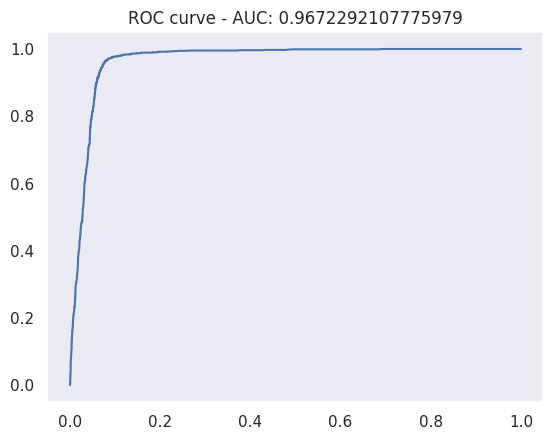

In [23]:
del str
y_pred_camem = trainer.predict(tokenized_text["test"])
y_pred = y_pred_camem
roc_camembert = roc_curve(y_test, y_pred.predictions[:,1])
auc = np.trapz(roc_camembert[1], roc_camembert[0])
plt.plot(roc_camembert[0], roc_camembert[1])
plt.title("ROC curve - AUC: " + str(auc))
plt.show()

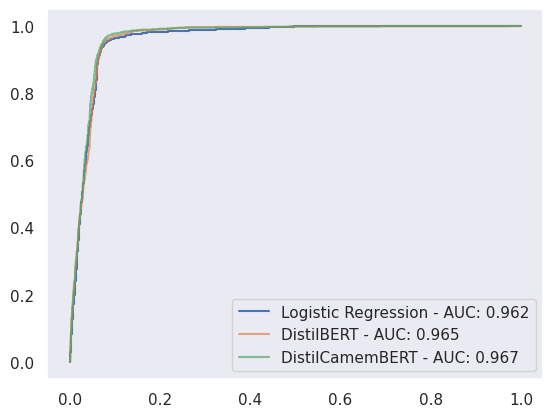

In [9]:

auc_logreg = np.round(np.trapz(roc_logreg[1], roc_logreg[0]), 3)
plt.plot(roc_logreg[0], roc_logreg[1], label="Logistic Regression - AUC: " + str(auc_logreg))
auc_distilbert = np.round(np.trapz(roc_distilbert[1], roc_distilbert[0]), 3)
plt.plot(roc_distilbert[0], roc_distilbert[1], label="DistilBERT - AUC: " + str(auc_distilbert), alpha = 0.7)
auc_camembert = np.round(np.trapz(roc_camembert[1], roc_camembert[0]), 3)
plt.plot(roc_camembert[0], roc_camembert[1], label="DistilCamemBERT - AUC: " + str(auc_camembert), alpha = 0.7)
plt.legend()
plt.show()



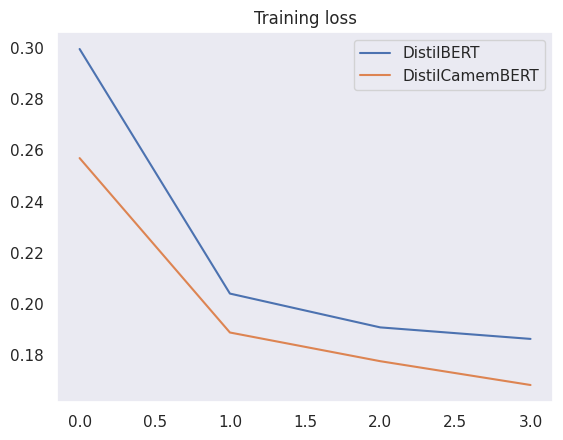

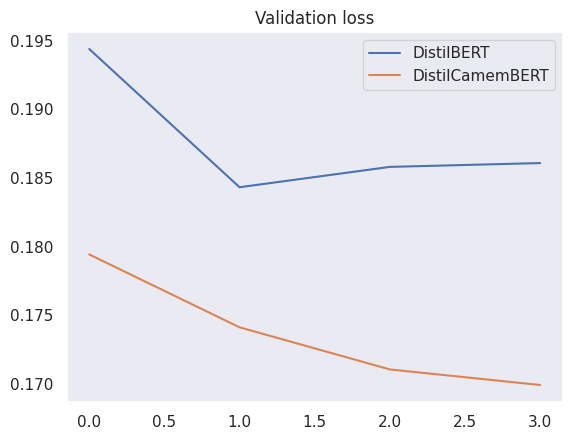

In [10]:
training_losses_distil = [0.299500, 0.204000, 0.190800, 0.186300]
val_losses_distil = [0.194385, 0.184315, 0.185797, 0.186075]
training_loss_cam = [0.256900, 0.188800, 0.177600, 0.168300]
val_losses_cam = [0.179419, 0.174110, 0.171042, 0.169907]


plt.plot(training_losses_distil, label="DistilBERT")
plt.plot(training_loss_cam, label="DistilCamemBERT")
plt.title("Training loss")
plt.legend()
plt.show()

plt.plot(val_losses_distil, label="DistilBERT")
plt.plot(val_losses_cam, label="DistilCamemBERT")
plt.title("Validation loss")
plt.legend()
plt.show()



In [24]:
from sklearn.metrics import normalized_mutual_info_score as nmi


print(nmi(y_pred_logreg, y_pred_camem.predictions.argmax(axis=1)))
print(nmi(y_pred_logreg, y_pred_distil.predictions.argmax(axis=1)))
print(nmi(y_pred_camem.predictions.argmax(axis=1), y_pred_distil.predictions.argmax(axis=1)))

0.7708552355254319
0.7731739682044785
0.8803772825334408


In [36]:
np.where(y_pred_logreg != y_pred_camem.predictions.argmax(axis=1))[0].astype(int)

array([  29,   43,   68,  139,  194,  231,  234,  249,  349,  415,  440,
        443,  455,  554,  582,  585,  597,  610,  654,  657,  703,  714,
        731,  732,  737,  750,  836,  841,  852,  947,  959,  994, 1024,
       1028, 1048, 1095, 1127, 1135, 1227, 1229, 1261, 1295, 1303, 1337,
       1576, 1584, 1726, 1763, 1795, 1808, 1919, 1941, 1974, 1977, 2045,
       2050, 2070, 2115, 2118, 2130, 2133, 2142, 2147, 2173, 2188, 2253,
       2277, 2278, 2335, 2366, 2380, 2405, 2410, 2510, 2514, 2585, 2633,
       2637, 2656, 2676, 2680, 2706, 2707, 2720, 2758, 2830, 2837, 2942,
       3047, 3104, 3160, 3176, 3190, 3210, 3226, 3234, 3284, 3315, 3372,
       3393, 3400, 3465, 3486, 3502, 3551, 3693, 3710, 3785, 3791, 3816,
       3872, 3909, 3942, 3958, 3970, 3978, 3981, 3984, 3992, 4018, 4024,
       4041, 4059, 4066, 4085, 4110, 4111, 4132, 4137, 4160, 4168, 4237,
       4242, 4247, 4248, 4268, 4338, 4346, 4359, 4379, 4392, 4420, 4502,
       4526, 4537, 4553, 4579, 4600, 4602, 4623, 46

In [57]:
np.array(dataset['test']['text'])[np.where(y_pred_logreg != y_test)[0].astype(int)]

array(['Lhort Victorine propriét re expl te chef 1862 idem Landos',
       'Couteau Mathurin meunier chef de m ge 47 Homme marié idem',
       'Legendre Jules marinier chef de ménage 30 française',
       'Jeruisse Louise chef 1869 idem chateaudun',
       'Cuchet Sylvy idem chef de ménage 31',
       'Gaulmin Auguste Cult chef de ménage 49 Homme marié française Fleuriel',
       'Petitjean Antoine domestique ch. d. m 36 Homme marié Vernusse',
       'Thierry s p cheg 1891 française Bonnebosq',
       'Ray Antoinette propriétaire chef 73 idem',
       'Corre Jean retraité chef 48 idem Sibiril',
       'Arrivé Fridolin carrier chef de ménage 36 65',
       'Fradin Jean forgeron chef de ménage patron 55 idem',
       'Bessette Pauline ménagère patronne 50 Roche',
       'Vaillant Auguste Journalier 62 Homme marié',
       'Négrier Elie métayer chef idem 1894 française idem',
       'Mallet Gilbert boulanger ch. d m 28 Homme marié Lazeret',
       'Mathaud François cultivateur chef de mén

In [56]:
np.array(dataset['test']['text'])[np.where(y_pred_camem.predictions.argmax(-1) != y_test)[0].astype(int)]

array(['Lhort Victorine propriét re expl te chef 1862 idem Landos',
       'Couteau Mathurin meunier chef de m ge 47 Homme marié idem',
       'Legendre Jules marinier chef de ménage 30 française',
       'Gilbert de Vantibault de la fontaine de Follin Anne sans profession 1896 francaisse Orléans',
       'Jeruisse Louise chef 1869 idem chateaudun',
       'Cuchet Sylvy idem chef de ménage 31',
       'Got Pierre voiturier Homme marié',
       'Gaulmin Auguste Cult chef de ménage 49 Homme marié française Fleuriel',
       'Thierry s p cheg 1891 française Bonnebosq',
       'Ray Antoinette propriétaire chef 73 idem',
       'Corre Jean retraité chef 48 idem Sibiril',
       'Arrivé Fridolin carrier chef de ménage 36 65',
       'Fradin Jean forgeron chef de ménage patron 55 idem',
       'Bessette Pauline ménagère patronne 50 Roche',
       'Vaillant Auguste Journalier 62 Homme marié',
       'Mallet Gilbert boulanger ch. d m 28 Homme marié Lazeret',
       'Mathaud François cultivateur

In [52]:
idx = np.where(y_pred_camem.predictions.argmax(-1) != y_test)[0].astype(int)[-5]
print(np.array(dataset['test']['text'])[idx])
print(y_test[idx])
print(y_pred_camem.predictions.argmax(-1)[idx])

Gresse Antoine idem chef de ménage 52
0
1
